In [ ]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 818 kB/s 


In [ ]:
import heapq
from utils import *
import math
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import nltk
from sklearn import metrics
nltk.download('punkt')
nltk.download('rslp')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [ ]:
#Importação do arquivo 'csv' para o python utilizando a biblioteca pandas

ds = pd.read_csv('olist.csv', delimiter=',')

#Remoçao das linhas com valores NaN e eliminação de exemplos positivos para balancear a base de dados
ds = ds.dropna()
ds_remove = ds.loc[(ds['rating'] == 4)]
ds = ds.drop(ds_remove.index)

X_col = 'review_text'
y_col = 'polarity'

X = ds.loc[:, X_col].values
y = ds.loc[:, y_col].values

#Tokenização
preprocessamento = PreProcessamento()
X = preprocessamento.tokenize(X)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Utilizar a biblioteca nltk para baixar a lista de stopwords em portugues

nltk.download('stopwords')
stopwords_ = stopwords.words('portuguese')

#Remoção da palavra 'não' da lista de stopwords, por apresentar relevância nessa classificação.
stopwords_.remove('não')

##Adicionar stopwords de acordo com as caracteristicas da base
stopword_list=[]
stopword_list.append('é')
stopword_list.append('vou')
stopword_list.append('que')

#Adiciona os valores para a lista
stopword_list.extend(stopwords_)

#Remove eventuais valores duplicados
stopword_list = list(set(stopword_list))

X = preprocessamento.remove_stopwords(X,stopword_list)

#Definição do dicionário para realizar standartization
std_list = {'eh': 'é', 'vc': 'você', 'vcs': 
'vocês','tb': 'também', 'tbm': 'também', 
'obg': 'obrigado', 'gnt': 'gente', 'q': 
'que', 'n': 'não', 'cmg': 'comigo', 'p': 
'para', 'ta': 'está', 
'to': 'estou', 'vdd': 'verdade', 'nao': 'não'}

##X = preprocessamento.apply_standardization(X, std_list)

X = preprocessamento.apply_stemmer(X)

##X = preprocessamento.generate_N_grams(X,2)

In [ ]:
#Construção de dicionário com a frequência de cada palavra do vocabulário

def bag_words(feature):
    wordfreq = {}
    for sentence in feature:
        for token in sentence:
            if token not in wordfreq.keys():
                wordfreq[token] = 1
            else:
                wordfreq[token] += 1
            
    return wordfreq

wordfreq = bag_words(X)

#Define as 5000 palavras mais frequentes para serem utilizadas como features
most_freq = heapq.nlargest(5000, wordfreq, key=wordfreq.get)

In [ ]:
#Função para transformar as palavras em códigos numéricos (de 1 a 5000)

def index(feature,most_freq):
    M = []
    for sentence in feature:
        L = []
        indice = ''
        for token in sentence:
            if token in most_freq:
                indice = most_freq.index(token)
                L.append(indice)
                #analisar o espaço no final de cada lista (documento)
        M.append(L)

    return M

X = index(X,most_freq)

#Cálculo do documento com maior número de palavras
def maior_comp(feature):
    maximo = 0
    cont = 0
    for sentence in feature:
        for token in sentence:
            cont+=1
        if cont>maximo:
            maximo = cont
        cont = 0
    return maximo

maximo = maior_comp(X)

#Igualar o número de palavras nos documentos
X = pad_sequences(X, value = 1, padding = 'post', maxlen = maximo)

In [ ]:
#Definição da base de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=1)

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Embedding, Dense, GlobalAveragePooling1D
from tensorflow.keras.callbacks import LambdaCallback

#Definição da rede neural 
model = Sequential([
    Embedding(5000, 16),
    GlobalAveragePooling1D(),
    Dense(16, activation = 'relu',kernel_regularizer=tf.keras.regularizers.l2(0.3)),
    Dense(1, activation = 'sigmoid')
])

model.compile(
    optimizer = 'adam',
    ##loss=tf.keras.losses.SparseCategoricalCrossentropy(), usar quando for softmax
    loss = 'binary_crossentropy',
    metrics = ['acc']
)

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 16)          80000     
_________________________________________________________________
global_average_pooling1d_11  (None, 16)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 17        
Total params: 80,289
Trainable params: 80,289
Non-trainable params: 0
_________________________________________________________________


0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.

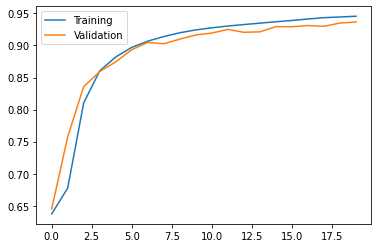

In [ ]:
simple_logging = LambdaCallback(on_epoch_end = lambda e, l: print(e, end='.'))

E = 20

#Treinamento da rede neural
h = model.fit(
    X_train, y_train,
    validation_split = 0.2,
    epochs = E,
    callbacks = [simple_logging],
    verbose = False
            )

#Análise da acuracidade de treino e teste
plt.plot(range(E),h.history['acc'], label = 'Training')
plt.plot(range(E),h.history['val_acc'], label = 'Validation')
plt.legend()
plt.show()

In [ ]:
#Fazer as previsões na base de teste

predictions = model.predict(X_test)

#Transformar a probabilidade em resultado e analisar os erros
erros = []
for i in range(0,len(predictions)):
    if predictions[i]>0.5:
        predictions[i]=1
    else:
        predictions[i]=0
    if predictions[i] != y_test[i]:
        erros.append(i)

#Analisar os resultados
matrix = metrics.confusion_matrix(y_test, predictions)

In [ ]:
##Avaliação do modelo

evaluation = Evaluation()

acc = evaluation.get_accuracy(matrix)
f_score = evaluation.f_score(matrix)

print(acc)
print(f_score)

0.9389183055975794
0.9147532330430193


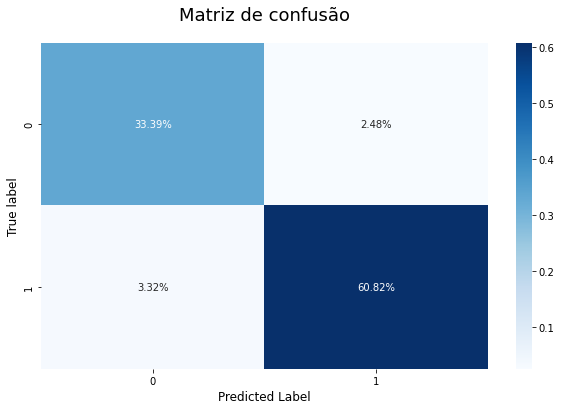

In [ ]:
#Define o plot
fig, ax = plt.subplots(figsize=(10,6))

title = "Matriz de confusão"

plt.title(title,fontsize=18)
ttl = ax.title
ttl.set_position([0.5,1.05])

##sns.heatmap(matrix, annot=True, fmt="",linewidths=0.30,ax=ax)
sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%', cmap='Blues',ax=ax)
ax.set_ylabel("True label",fontsize=12)
ax.set_xlabel("Predicted Label",fontsize=12)
plt.show()